# Tabular Playground September 2021

# Load Data

In [1]:
import os
import numpy as np
import pandas as pd
test = pd.read_csv('datasets/test.csv')
train = pd.read_csv('datasets/train.csv')

In [2]:
lst_train_dtypes = train.dtypes.value_counts()
print(lst_train_dtypes)

float64    118
int64        2
dtype: int64


All features are float and the index and 'claim' columns are int.  'claim' is the target variable.

# EDA

## Mutual Information

Before splitting the data I'm going to run an analysis of mutual information to see if there is any potentially important feature to use in a stratified split.

### Run MI

In order to run the intial MI analysis, I need to resolve all NaN values.

In [3]:
rows_with_na = train.shape[0] - train.dropna(axis=0).shape[0]
print("There are", rows_with_na, "rows with at least one missing value, out of", train.shape[0], "total rows in the training set.")

There are 598455 rows with at least one missing value, out of 957919 total rows in the training set.


Since there are so many rows with missing values, I will impute with median values for this initial exploratory MI exercise.  I may reevaluate this decision later when I build the model pipeline.  I will also go ahead and standardize before the MI.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

prep_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

y_init_mi = train.claim
X_init_mi = prep_pipeline.fit_transform(train.drop(['id', 'claim'], axis=1))
X_init_mi = pd.DataFrame(X_init_mi, columns=train.drop(['id', 'claim'], axis=1).columns)

In [5]:
from sklearn.feature_selection import mutual_info_classif
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_init_mi, y_init_mi)

In [6]:
mi_scores.head(10)

f40     0.003423
f6      0.003340
f4      0.003209
f44     0.003198
f11     0.003103
f70     0.003033
f78     0.003009
f38     0.002999
f115    0.002997
f86     0.002903
Name: MI Scores, dtype: float64

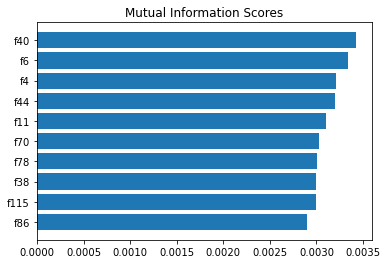

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plot_mi_scores(mi_scores.head(10))

MI scores are very low for all features.  `f40` has the highest score with 0.003423.  There are quite a few features with MI scores equal to 0 however, suggesting that the target variable is independent of each.  We **may** be able to drop those features.

In [8]:
zero_mi_scores = mi_scores[mi_scores == 0]
zero_mi_scores.shape
print(zero_mi_scores.shape[0], "of the", mi_scores.shape[0], "features have MI scores equal to zero")

0 of the 118 features have MI scores equal to zero


### Visualize MI

Now taking a look at the three most informative features.

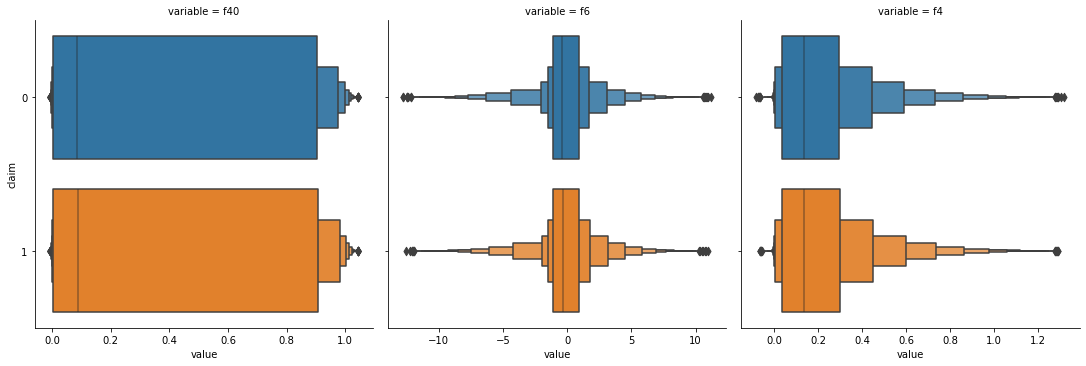

In [9]:
features = mi_scores.iloc[:3].index.values.tolist()
plot_df = train.melt(id_vars='claim', value_vars=features)
plot_df['claim'] = plot_df.claim.astype('category')
sns.catplot(x="value", y="claim", col="variable", data=plot_df, kind="boxen", sharex=False);

None of these features appear to be very informative towards predicting the variation in the target variable.  I may have wasted my time with this analysis.  Oh well, moving on to the PCA.  Maybe I'll have better luck after the PCA.

## Split Validation Set

Since the training set is so large, I'm going to split out a validation set of only 10%. This still equates to nearly 100k observations.

In [10]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(train, test_size=0.1)

# PCA & Feature Selection

In an attempt to reduce dimensionality, I'm now going to run a PCA on all of the features.  I'll then select an appropriate number of PCs to include in the final model directly, adding the PCA to my final pipeline.

In [11]:
X_train = df_train.drop(['id', 'claim'], axis=1)
y_train = df_train.claim

X_train_prep = prep_pipeline.fit_transform(X_train)

from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_train_prep)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

In [12]:
#function for plotting explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

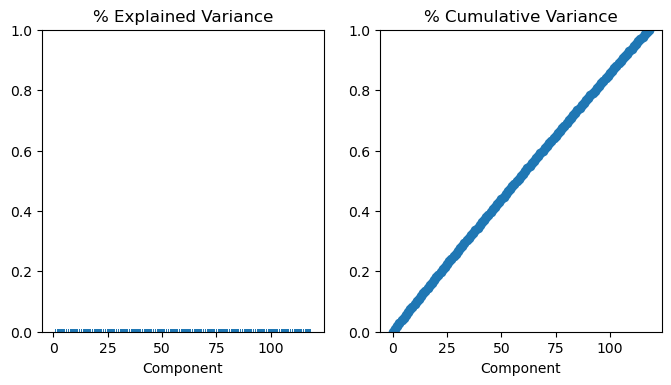

In [13]:
plot_variance(pca)
plt.show()

I'm quite surprised by the results of the PCA.  The plots above suggest that each PC is extracting the same amount of variance.  This could mean that the features are all orthogonal to each other, though this is hard to believe.  Whatever the explanation, unless I made a mistake above, it appears that the PCA has no value for dimensionality reduction in this case. 

Could this have something to do with the large amount of imputations I'm doing?  I'll rerun the PCA after dropping all rows with NaN below.

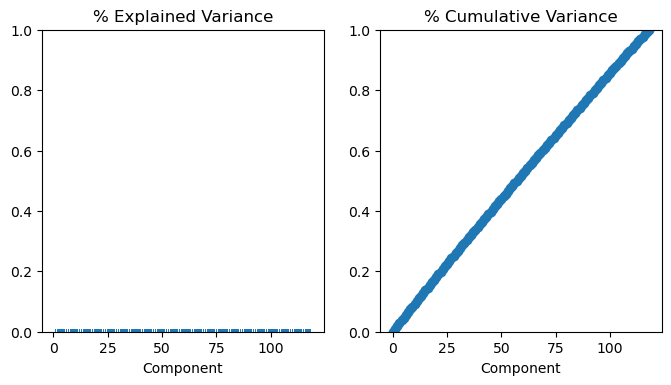

In [14]:
X_noNA = X_train.dropna()
X_train_noNA_prep = prep_pipeline.fit_transform(X_noNA)

pca_noNA = PCA()
X_pca_noNA = pca_noNA.fit_transform(X_train_noNA_prep)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca_noNA.shape[1])]
X_pca_noNA = pd.DataFrame(X_pca_noNA, columns=component_names)

#plot results
plot_variance(pca_noNA)
plt.show()

Well I can confidently say that's not the issue.  The PCA still seems equally as worthless.  Each component extracts the exact same amount of variance.

# RFE?

# ML Pipeline

# Evaluation

